<h3 align="center">Note for graders: the code will run, but it will run slowly</h3> 

<u><h1 align="center">Introduction</h1> </u>

Pittsburgh, PA has an infamous reputation for being a polluted city. This primarily stems from the city's now defunct steel industry, that used to blot out the sun at midday with its smoke, and who knows what else seeped into the water and land. We wanted to check in on the state of pollution in the city, and determine the cleanest spot to reside. There are many datasets on the WPRDC about different toxins. Other than the datasets we used below, there were other indicators of pollution like lead content in peoples' blood by school district. We chose the our datasets for their size, variety, and accuracy.

<u><h1 align="center">Metrics</h1> </u>

Our metric describes the best neighborhood in Pittsburgh as the one with the least amount of dangerous pollutants. We wanted to focus on what can make you sick, so we referenced datasets with carcinogenic land releases, carcinogenic air releases, and asbestos square footage, which can cause many illnesses and increase cancer risk. We are using the Toxic Release Inventory (Land), Allegheny County Asbestos Permits, and Toxic Release Inventory (Air) datasets. These are further explored below.

<u><h1 align="center">Datasets</h1> </u>
<h3 align="center">Toxic Release Inventory (Land)</h3> 
The EPA (Environmental Protection Agency) requires companies to report certain data regarding harmful waste that they release/dump onto land. This data ranges from information about the companies, the specific locations of the dump sites, information about the toxic compounds being dumped, as well as other, more technical information. For the purpose of our analysis, we will focus on the amount of carginogenic materials dumped in Pittsburgh neighborhoods. Specfically, we will look at the number of reported instances of carcinogenic material dumps on land.

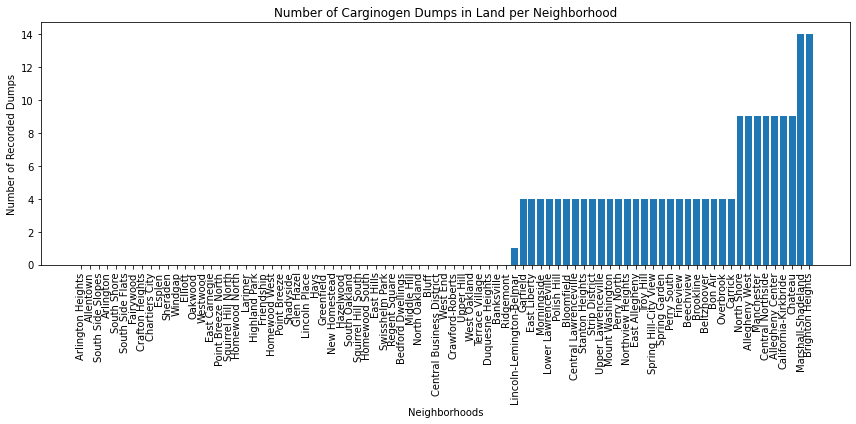

Text(0.5, 1.0, 'Number of Recorded Carcinogen Dumps onto Land per Neighborhood')

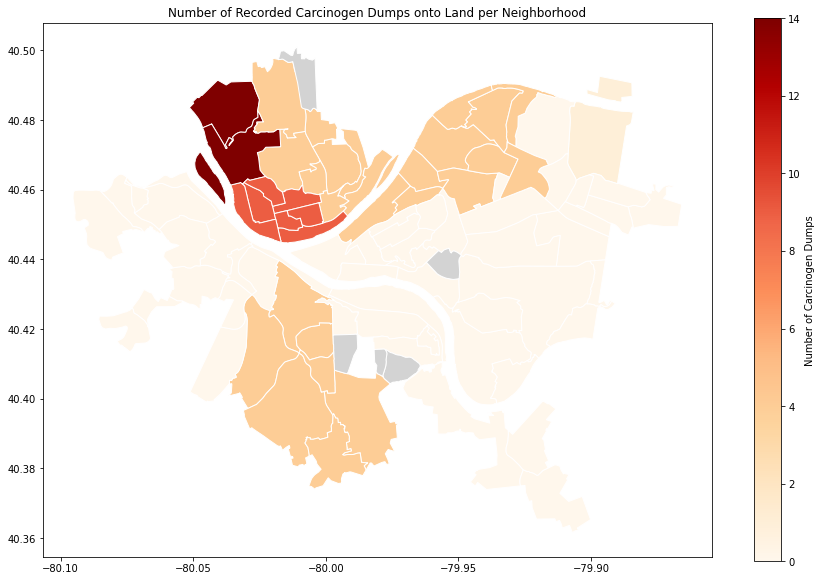

In [2]:
#imports
import pandas as pd
import fpsnippets
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt

#read in our data
data = pd.read_csv("land-toxic-release.csv",  usecols = ['CITY_NAME','COUNTY_NAME', 'STATE_ABBR', 'ZIP_CODE', 'REPORTING_YEAR', 'CHEM_NAME', 'CARCINOGEN'])

stateMask = data['STATE_ABBR'] == "PA" #create masks on data
cityMask = data['CITY_NAME'] == "PITTSBURGH"
countyMask = data['COUNTY_NAME']== "ALLEGHENY"
#let's now use these query masks to get only the info for Allegheny County in Pittsburgh,PA
relevantData = data[stateMask & cityMask & countyMask]

#get a list of unique zip codes in the area
zips = relevantData['ZIP_CODE'].unique()
zips.sort()
landDict=dict() #we will store neighborhoods and their carcinogen counts in this dictionary

#count the number of carniogens found in each zip code using a loop
x = 0;
for zip in zips:
    carcCounter = 0;
    mask = relevantData['ZIP_CODE'] == zip
    maskedData = relevantData[mask] #get the data for the specific zipcode
    for row in maskedData:
        carcYorN = relevantData.iloc[x,6]
        if carcYorN == "Y": #if the chemical is a carcinogen, increment our carc counter
            carcCounter = carcCounter + 1
        x = x + 1
    #Store the count of the carcinogens for each neighborhood in the current zipcode
    #into the dictionary
    neighborhoods = fpsnippets.zip_to_neighborhoods(zip)
    if neighborhoods is not None:
        for neighborhood in neighborhoods:
            if neighborhood in landDict:
                landDict[neighborhood] += carcCounter
            else: 
                landDict[neighborhood] = carcCounter
#sort the data
sortedLandDict = dict(sorted(landDict.items(), key=lambda item: item[1]))
landDF = pd.Series(sortedLandDict).to_frame()

#create a bargraph of info using matlib
plt.figure(figsize=(12, 6)) 
plt.bar(landDF.index, landDF[0])
plt.xlabel("Neighborhoods")  
plt.ylabel("Number of Recorded Dumps")  
plt.title("Number of Carginogen Dumps in Land per Neighborhood") 
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

#create a map using geopadas
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
landMap = neighborhoods.merge(landDF, how='left', left_on='hood', right_index=True)

landMap.plot(column= 0, 
               cmap='OrRd',             
               edgecolor="white",        
               legend=True,  
               legend_kwds={'label': "Number of Carcinogen Dumps"}, 
               figsize=(15, 10),         
               missing_kwds={"color": "lightgrey"} 
               )
plt.title("Number of Recorded Carcinogen Dumps onto Land per Neighborhood")

<h3 align="center">Allegheny County Asbestos Permits</h3> 

The EPA requires all asbestos to be removed from buildings. Asbestos can cause asbestosis, mesothelioma, and lung cancer. It continues to be a dangerous chemical, as it was used in contruction as both insulation and fire retardant, and used to be one of the best and cheapest options. The progress to clean up after its widespread use has been slow. This dataset shows all previous and active asbestos work in the city of Pittsburgh. All of the data is relatively recent, starting on January 1st, 2014. The latitude and longitude were given, so the asbestos content by square foot could easily be measured on a per-neighborhood basis using the fpsnippets code. Below is both the bar graph and heat map representation of asbestos usage in Pittsburgh. Anecdotally, the data makes sense  for the worst poluugiven the high concentration and size of buildings in the central business district that were erected before asbestos was outlawed.

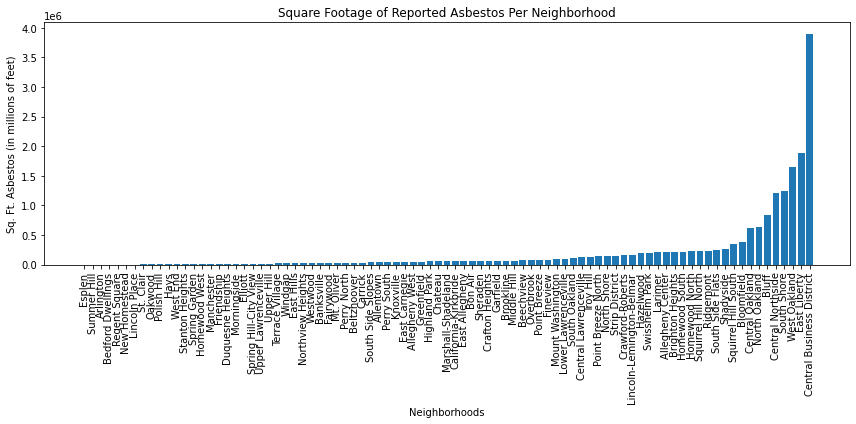

Text(0.5, 1.0, 'Square Footage of Reported Asbestos Per Neighborhood')

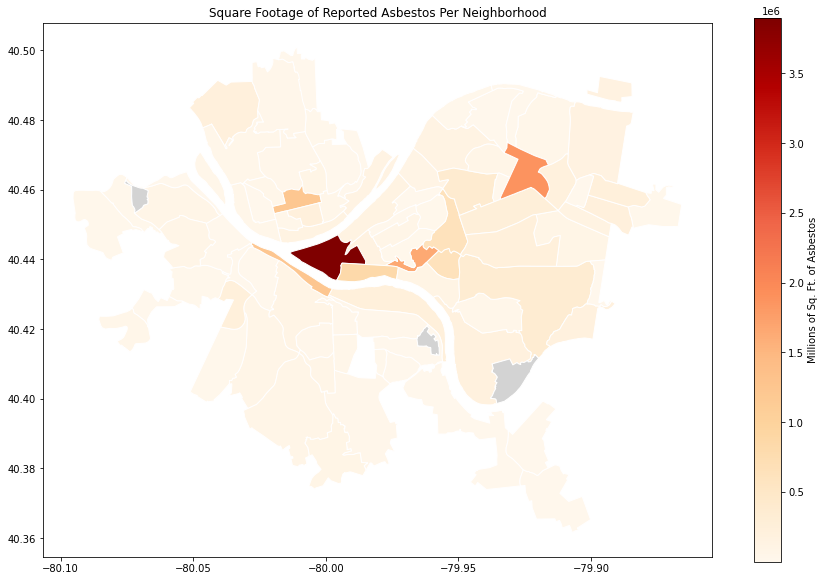

In [3]:
#imports
import pandas as pd
import fpsnippets
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt

#importing relevant columns
asb = pd.read_csv("asbestos_dataset.csv", usecols = ['city', 'square_feet', 'latitude','longitude'])

#filtering out no given lat and long
asb = asb[~asb.latitude.isnull()]

#filtering out no given square feet
asb = asb[~asb.square_feet.isnull()]

#make a 2D array of neighborhoods and square footage of asbestos?
nghDict = dict()

#iterates through to gather sq ft data per neighborhood
for index, row in asb.iterrows():
    #determine neighborhood of latitude and longitude
    lat = row['latitude']
    long = row['longitude']
    neighborhood = fpsnippets.geo_to_neighborhood(lat,long)

    #parse neighborhoods and associated square footage of asbestos with them
    if neighborhood is not None:
        if neighborhood in nghDict:
            nghDict[neighborhood] += int(row['square_feet'])
        else:
            #add new entry
            nghDict[neighborhood] = int(row['square_feet'])
    
#sorting and converting back to a dataframe
sorted_nghDict = dict(sorted(nghDict.items(), key=lambda item: item[1]))
nghDF = pd.Series(sorted_nghDict).to_frame()


#plot it using matplotlib
plt.figure(figsize=(12, 6)) 
plt.bar(nghDF.index, nghDF[0])  
plt.xlabel('Neighborhoods')  
plt.ylabel('Sq. Ft. Asbestos (in millions of feet)')  
plt.title('Square Footage of Reported Asbestos Per Neighborhood') 
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

#make geopandas heat map
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") 
asb_map = neighborhoods.merge(nghDF, how='left', left_on='hood', right_index=True)
asb_map.plot(column= 0, 
               cmap='OrRd',              
               edgecolor="white",       
               legend=True,              
               legend_kwds={'label': "Millions of Sq. Ft. of Asbestos"}, 
               figsize=(15, 10),         
               missing_kwds={"color": "lightgrey"} 
               )
plt.title('Square Footage of Reported Asbestos Per Neighborhood')

<h3 align="center">Toxic Release Inventory (Air)</h3> 

The EPA monitors the release of a huge number of chemicals with varying levels of toxicity. To narrow that down in this dataset, we only focused on the carcinogens and the amount that has been released into the air. The dataset only gave zipcodes, which means neighborhoods within a zipcode have the same data, however, this works well for airbourne toxins as they are hard to localize to begin with. Below is the bar graph and heat map showing the most heavily polluted areas with airbourne carcinogens, starting in 1997. Anecdotally, the data makes sense given the low industry presence in zipd code 15203 (rlington Heights, Allentown, South Side Slopes, Arlington, South Side Flat, Cartiers City, and Esplen).

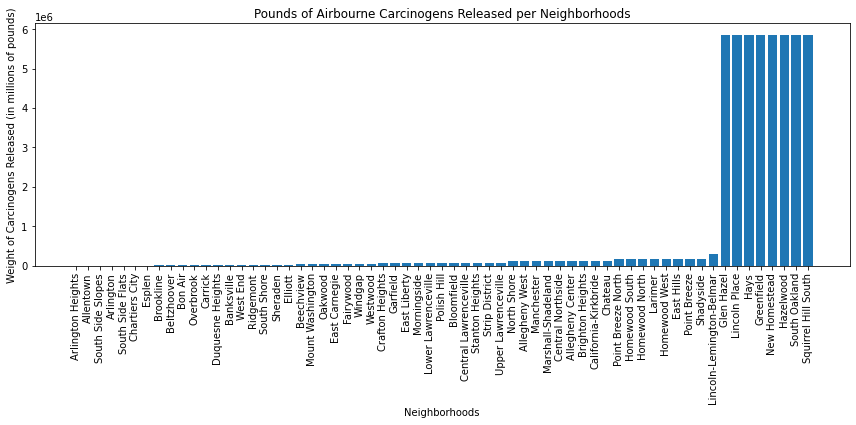

Text(0.5, 1.0, 'Pounds of Airbourne Carcinogens Released per Neighborhoods')

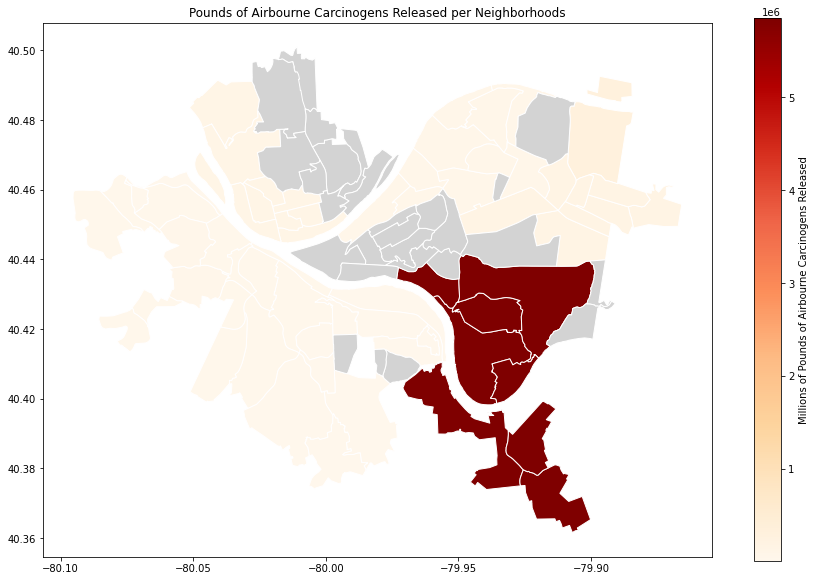

In [4]:
#imports
import pandas as pd
import fpsnippets
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#masking
air = pd.read_csv("filtered_tri_air.csv", usecols = ['CITY_NAME','COUNTY_NAME', 'ZIP_CODE', 'CARCINOGEN','REL_EST_AMT'])
pittsburgh = air['CITY_NAME'] == "PITTSBURGH"
air = air[pittsburgh]

#get zips and trim to 5 char zips
air = air[air['ZIP_CODE'].astype(str).str.len() <= 5]
air['ZIP_CODE'] = air['ZIP_CODE'].astype(int)

#add weight of release to each neighborhood in the zip code
airDict=dict()
for index, row in air.iterrows():
    #get relevant neighborhoods for this row
    zip_code = row['ZIP_CODE']
    neighborhoods = fpsnippets.zip_to_neighborhoods(zip_code)
    
    for i in neighborhoods:
        if i in airDict:
            if row['CARCINOGEN'] == 'Y':
                airDict[i] += int(row['REL_EST_AMT'])
    
        else:
            if row['CARCINOGEN'] == 'Y':
                airDict[i] = int(row['REL_EST_AMT'])


#sort
sorted_airDict = dict(sorted(airDict.items(), key=lambda item: item[1]))
airDF = pd.Series(sorted_airDict).to_frame()

#plot it using matplotlib
plt.figure(figsize=(12, 6)) 
plt.bar(airDF.index, airDF[0])  # Assuming the index represents the x-axis values
plt.xlabel('Neighborhoods')  
plt.ylabel('Weight of Carcinogens Released (in millions of pounds)')  
plt.title('Pounds of Airbourne Carcinogens Released per Neighborhoods') 
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

#get shapefield and merge
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
air_map = neighborhoods.merge(airDF, how='left', left_on='hood', right_index=True)

#geopandas plot
air_map.plot(column= 0, 
               cmap='OrRd',             
               edgecolor="white",        
               legend=True,  
               legend_kwds={'label': "Millions of Pounds of Airbourne Carcinogens Released"}, 
               figsize=(15, 10),         
               missing_kwds={"color": "lightgrey"} 
               )
plt.title('Pounds of Airbourne Carcinogens Released per Neighborhoods')

<u><h1 align="center">Results</h1> </u>

The best way to visualize three metrics of pollution that have different units of measurement was to weight them on a graph to show their relative prevelance. Air and asbestos both weighed in millions of pounds, and thus were easy to compare. However, carcinogenic dumps didn't have a weight provide. To get it to show on the data, we multiplied the number of dumps by the constant 100,000 to show its relative amounts. Below is a visualization of the amounts of pollutants displayed in a bar graph. As you can see, Esplen and Arlington are both on the extremely low end of pollutants. We printed these neighborhoods from the dataset to compare. **Arlington** wins out as the best neighborhood in Pittsburgh when you are considering which is the least toxic neighborhood to live in.


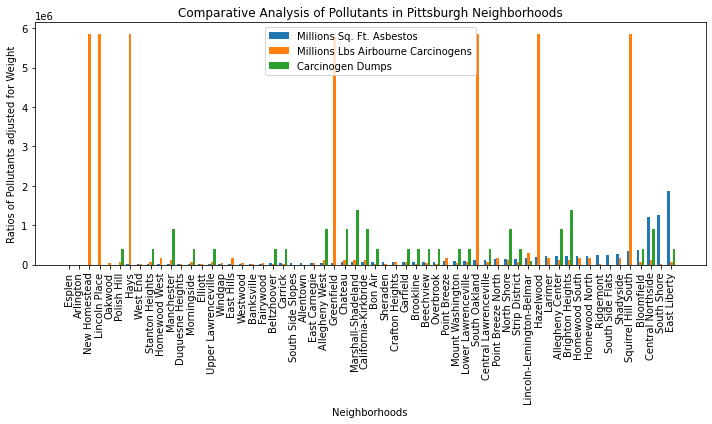

,Millions Sq. Ft. Asbestos,Millions Lbs Airbourne Carcinogens,Carcinogen Dumps
Esplen,800,333,0
Arlington,910,275,0


In [52]:
#merge and rename DF
DF = pd.merge(nghDF, airDF, left_index = True, right_index = True) 
df = pd.merge(DF, landDF, left_index = True, right_index = True)
df = df.rename(columns={'0_x' : 'Millions Sq. Ft. Asbestos'})
df = df.rename(columns={'0_y' : 'Millions Lbs Airbourne Carcinogens'})
df = df.rename(columns={0 : 'Carcinogen Dumps'})

#weight carcinogen dumps so it shows up in analysis given it doesnt have a weight metric
df['Carcinogen Dumps'] = df['Carcinogen Dumps'] * 100000

#graph adjustments and bar creation
bar_width = 0.25
index = range(len(df.index))
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, df['Millions Sq. Ft. Asbestos'], width=bar_width, label='Millions Sq. Ft. Asbestos')
bar2 = ax.bar([i + bar_width for i in index], df['Millions Lbs Airbourne Carcinogens'], width=bar_width, label='Millions Lbs Airbourne Carcinogens')
bar3 = ax.bar([i + 2 * bar_width for i in index], df['Carcinogen Dumps'], width=bar_width, label='Carcinogen Dumps')

#label the graph
ax.set_xlabel('Neighborhoods')
ax.set_ylabel('Ratios of Pollutants adjusted for Weight')
ax.set_title('Comparative Analysis of Pollutants in Pittsburgh Neighborhoods')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(df.index)
ax.legend()

#adjust labels and plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#show the two lowest neighborhoods to see which one is comparatively better
df[0:2]

<u><h1 align="center">Conclusion</h1> </u>

Kate: Our conclusion is about what I anticipated for this analysis. One of the most sparsely populated neighborhoods in Pittsburgh had to win out by nature of human population and pollution. However, I'm relatively confident that the protections in place by the EPA makes most neighborhoods inhabitable with no huge risk to our health, so my personal metric generally relies on bus accessibility, restaurants, parks, cost of living, and architecture. For this reason, my favorite neighborhood is Bloomfield, which did pretty well in our analysis.

Feyza: I was kind of surprised by how much variety there was across the neigborhoods, despite them all being relatively close to one another. I don't have a true favorite when it comes to neighborhood, but if I had to pick, I think I'd say Point Breeze just because it seems a little calmer. This neighborhood also did relatively well in our comparisons, so I think it seems that it would be a decent place to live!